In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.sparse as sp
from cupyx.scipy.sparse.linalg import gmres
from scipy.sparse.linalg import cg
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as scp
np.set_printoptions(linewidth=300, precision=3)

from qmat import QDELTA_GENERATORS

from pySDC.core.collocation import CollBase
from pySDC.implementations.problem_classes.HeatEquation_ND_FD import heatNd_unforced
from pySDC.implementations.problem_classes.AllenCahn_2D_FD import allencahn_fullyimplicit
from pySDC.implementations.problem_classes.GeneralizedFisher_1D_FD_implicit import generalized_fisher

In [2]:
class counter(object):
    def __init__(self, disp=False):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            # print('iter %3i\trk = %s' % (self.niter, str(rk)))
            print('   LIN: %3i' % self.niter)
    def get_iter(self):
        return self.niter

In [3]:
def nonlinear_sdc(dt = 0.0005, num_nodes = 4, nvars = (64, 64), nu = 2, eps=0.04,
                  abs_tol = 1E-12, rel_tol = 1E-12, k_max = 10_000, n_max = 10_000):
    # instantiate problem
    prob = allencahn_fullyimplicit(nvars=nvars, nu = nu, eps = eps)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MIN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = cp.asarray(generator.genCoeffs(k=None))


    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = cp.asarray(coll.Qmat[1:, 1:])

    u0 = cp.asarray(prob.u_exact(t=0).flatten())
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = cp.kron(cp.ones(coll.num_nodes), u0)

    nvars = prob.nvars[0] * prob.nvars[1]

    uk = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    fk = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    rhs = cp.zeros(nvars * coll.num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    timepoints = cp.arange(0, 0.01+dt, step=dt)
    u_buffer = cp.empty((len(timepoints), nvars))
    conv_buffer = cp.zeros(len(timepoints)) # marks the iteration, reaching the disered tolerances
    conv_buffer[0] = 1
    u_buffer[0, :] = u0

    count = counter()
    for index, timepoint in enumerate(timepoints[:-1]):
        k = 0
        #print(timepoint)
        while k < k_max:
            # eval rhs
            for m in range(coll.num_nodes):
                fk[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(uk[m * nvars: (m + 1) * nvars].get(),
                                                             t=timepoint + dt * coll.nodes[m]).flatten())
    
            resnorm = cp.linalg.norm(u0_coll - (uk - dt * sp.kron(Q, sp.eye(nvars)).dot(fk)), cp.inf)
            #print('SDC:', k, ksum, resnorm)
            if resnorm < abs_tol and resnorm/cp.linalg.norm(u0_coll, cp.inf) < rel_tol:
                conv_buffer[index+1] = 1 # this iteration converged
                break
    
            g = cp.zeros(nvars * coll.num_nodes, dtype='float64')
            vn = uk
            fn = cp.zeros(nvars * coll.num_nodes, dtype='float64')
            n = 0
            while n < n_max:
                for m in range(coll.num_nodes):
                    fn[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(vn[m * nvars: (m + 1) * nvars].get(),
                                                                 t=timepoint + dt * coll.nodes[m]).flatten())
                g[:] = u0_coll + dt * sp.kron(Q-QDmat, sp.eye(nvars)).dot(fk) - (vn - dt * sp.kron(QDmat, sp.eye(nvars)).dot(fn))
    
                # if g is close to 0, then we are done
                res_newton = cp.linalg.norm(g, cp.inf)
                rel_err = cp.linalg.norm(vn-uk, cp.inf) 
                #print('  Newton:', n, res_newton)
                n += 1
                nsum += 1
                if res_newton < abs_tol and rel_err < rel_tol * cp.linalg.norm(vn, cp.inf):
                    break
    
                # assemble dg
                dg = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * vn ** prob.nu), offsets=0))
    
                # Newton
                # vk =  sp.linalg.spsolve(dg, g)
                vn -= gmres(dg, g, x0=cp.zeros_like(vn), maxiter=1000, atol=1E-14, callback=count, callback_type='pr_norm')[0]
    
            uk = vn.copy()
    
            k += 1
            ksum += 1
        temp = uk[-nvars:]
        u_buffer[index+1, :] = temp
        u0_coll = cp.kron(cp.ones(coll.num_nodes), temp).flatten()

    return u_buffer, timepoints, prob, ksum, nsum, conv_buffer

In [4]:
allencahn = allencahn_fullyimplicit(nvars = (64, 64))

In [5]:
%%time
u1, t1, prob, ksum, nsum, conv_buffer = nonlinear_sdc(dt=0.0005, num_nodes = 10, nvars=(64, 64), n_max=1)
print((ksum, nsum))
cp.linalg.norm(u1[-1]-cp.asarray(prob.u_exact(t1[-1]).flatten()), np.inf)

(302, 302)
CPU times: user 5.29 s, sys: 0 ns, total: 5.29 s
Wall time: 5.29 s


array(3.59601238e-13)

In [6]:
columns = ["method", "problem","tol", "dt", "quad_nodes", "nvars", "new_max", "sdc_sum", "new_sum", "norm"]
table = pd.DataFrame(columns=columns)

for dt in [0.0005, 0.00005]:
    for quadn in [2, 3, 4, 5]:
        for nvars in [(64, 64), (128, 128), (256, 256)]:
            for niter in [1, 2, 3, 5, 10, 20]:
                print((dt, quadn, nvars, niter))
                u1, t1, prob, ksum, nsum, conv_buffer = nonlinear_sdc(dt=dt, num_nodes = quadn, nvars=nvars, n_max=niter)
                max_norm = cp.linalg.norm(u1[-1]-cp.asarray(prob.u_exact(t1[-1]).flatten()), np.inf)
                row = ["sdc_newton", "allencahn", 1E-12, dt, quadn, nvars, niter, ksum, nsum, max_norm.get()]
                table.loc[len(table.index)] = row

table

(0.0005, 2, (64, 64), 1)
(0.0005, 2, (64, 64), 2)
(0.0005, 2, (64, 64), 3)
(0.0005, 2, (64, 64), 5)
(0.0005, 2, (64, 64), 10)
(0.0005, 2, (64, 64), 20)
(0.0005, 2, (128, 128), 1)
(0.0005, 2, (128, 128), 2)
(0.0005, 2, (128, 128), 3)
(0.0005, 2, (128, 128), 5)
(0.0005, 2, (128, 128), 10)
(0.0005, 2, (128, 128), 20)
(0.0005, 2, (256, 256), 1)
(0.0005, 2, (256, 256), 2)
(0.0005, 2, (256, 256), 3)
(0.0005, 2, (256, 256), 5)
(0.0005, 2, (256, 256), 10)
(0.0005, 2, (256, 256), 20)
(0.0005, 3, (64, 64), 1)
(0.0005, 3, (64, 64), 2)
(0.0005, 3, (64, 64), 3)
(0.0005, 3, (64, 64), 5)
(0.0005, 3, (64, 64), 10)
(0.0005, 3, (64, 64), 20)
(0.0005, 3, (128, 128), 1)
(0.0005, 3, (128, 128), 2)
(0.0005, 3, (128, 128), 3)
(0.0005, 3, (128, 128), 5)
(0.0005, 3, (128, 128), 10)
(0.0005, 3, (128, 128), 20)
(0.0005, 3, (256, 256), 1)
(0.0005, 3, (256, 256), 2)
(0.0005, 3, (256, 256), 3)
(0.0005, 3, (256, 256), 5)
(0.0005, 3, (256, 256), 10)
(0.0005, 3, (256, 256), 20)
(0.0005, 4, (64, 64), 1)
(0.0005, 4, (64

,method,problem,tol,dt,quad_nodes,nvars,new_max,sdc_sum,new_sum,norm
0,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",1,207,207,2.2793413507748994e-06
1,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",2,205,410,2.2793417274735717e-06
2,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",3,205,492,2.2793417259192594e-06
3,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",5,205,514,2.2793417259192594e-06
4,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",10,205,515,2.2793417259192594e-06
...,...,...,...,...,...,...,...,...,...,...
139,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",2,1052,2104,2.4666380049609415e-12
140,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",3,1052,2462,2.4665824938097103e-12
141,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",5,1052,2463,2.4665824938097103e-12
142,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",10,1052,2463,2.4665824938097103e-12


In [7]:
table.to_csv("sdcnew_allencahn_table.csv")

In [8]:
dts_allen = 5/cp.logspace(3, 5, num=5)
print(dts_allen)
norms_allen = cp.empty(len(dts_allen))

for index, dt in enumerate(dts_allen):
    print("loop index: " + str(dt))
    u, t, prob, ksum, nsum, conv_buffer= nonlinear_sdc(dt = float(dt), num_nodes = 4, abs_tol=1E-14, rel_tol=1E-14)
    u_exact_allen =cp.asarray(prob.u_exact(t[-1]))
    norms_allen[index] = cp.max(cp.abs(u[-1] - u_exact_allen.flatten()))

[5.00000000e-03 1.58113883e-03 5.00000000e-04 1.58113883e-04
 5.00000000e-05]
loop index: 0.005
loop index: 0.0015811388300841895
loop index: 0.0005
loop index: 0.00015811388300841897
loop index: 5e-05


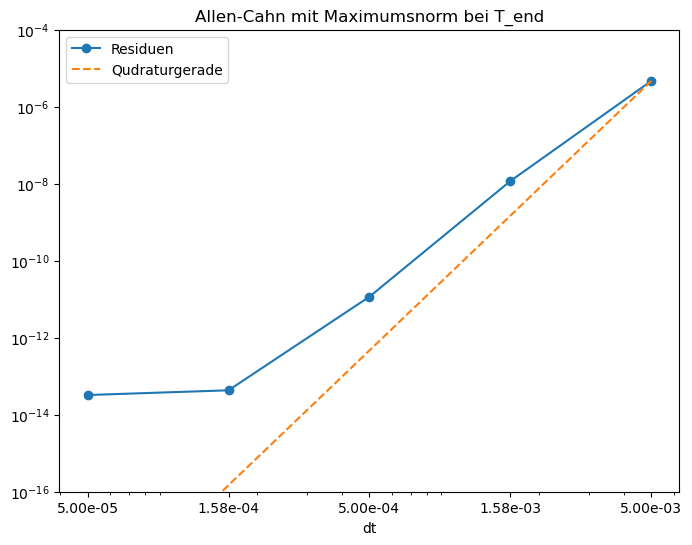

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
conv_line = cp.power(dts_allen, 7) * norms_allen[0]/np.power(dts_allen[0], 7)
ax.plot(dts_allen.get(), norms_allen.get(), marker = "o", label="Residuen")
ax.plot(dts_allen.get(), conv_line.get(), linestyle="dashed", label="Qudraturgerade")
ax.set_xscale("log", base = 10)
ax.set_xticks(dts_allen.get(), labels=["{:.2e}".format(dt) for dt in dts_allen.get()])
ax.set_yscale("log", base = 10)
ax.set_ylim(1E-16, 1E-4)
plt.xlabel("dt")
plt.legend()
ax.set_title("Allen-Cahn mit Maximumsnorm bei T_end")
plt.savefig("allencahn_maximumsnorm.png")

In [38]:
def nonlinear_sdc_fisher(dt = 0.05, t_end = 0.1, num_nodes = 5, nvars = 127, atol = 1E-7, rtol=1E-7, 
                         k_max = 10_000, n_max = 1_000, nu=1.0, lambda0=2.0 ):
    # instantiate problem
    prob = generalized_fisher(nvars=nvars, nu=nu, lambda0=lambda0)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = generator.genCoeffs(k=None)
    num_nodes = coll.num_nodes 


    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = coll.Qmat[1:, 1:]

    u0 = prob.u_exact(t=0).flatten()
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = np.kron(np.ones(num_nodes), u0)

    nvars = prob.nvars 

    uk = u0_coll
    print("--------------------")
    fk = np.zeros(nvars * num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    newton_res_buffer = np.array([])
    timepoints = np.arange(start = 0, stop = t_end+dt, step = dt)
    u_buffer = np.empty((len(timepoints), nvars)) 
    u_buffer[0] = u0
#    lam1 = prob.lambda0/2.0 * ((prob.nu/2.0 + 1) ** 0.5 + (prob.nu/2.0 + 1) **(-0.5))
#    sig1 = lam1 - np.sqrt(lam1**2-prob.lambda0**2)

    count = counter()
    for index, timepoint in enumerate(timepoints[:-1]): 
        k = 0
        while k < k_max:
            ksum +=1
            # eval rhs
            for m in range(num_nodes):
                fk[m * nvars: (m + 1) * nvars] = prob.eval_f(uk[m * nvars: (m + 1) * nvars],
                                                             t=timepoint + dt * coll.nodes[m]).flatten()
    
          
            resnorm = np.linalg.norm(u0_coll - (uk - dt * scp.kron(Q, scp.eye(nvars)).dot(fk)), np.inf)
            #print('SDC:', k, ksum, resnorm)
            if resnorm < atol and resnorm/np.linalg.norm(u0)< rtol:
                break
            g = np.zeros(nvars * num_nodes, dtype='float64')
            vn = uk
            fn = np.zeros(nvars * num_nodes, dtype='float64')
            n = 0
            res_newton = 0
            while n < n_max:
                nsum +=1
                for m in range(num_nodes):
                    fn[m * nvars: (m + 1) * nvars] = prob.eval_f(vn[m * nvars: (m + 1) * nvars],
                                                                 t=timepoint + dt * coll.nodes[m]).flatten()
                g[:] = u0_coll + dt * scp.kron(Q-QDmat, scp.eye(nvars)).dot(fk) - (vn - dt * scp.kron(QDmat, scp.eye(nvars)).dot(fn))
                
                # if g is close to 0, then we are done
                res_newton = np.linalg.norm(g, np.inf)
                rel_err = np.linalg.norm(vn-uk, np.inf) 
                #print('  Newton:', n, res_newton)
                n += 1
                if res_newton < atol: # and rel_err < rtol * np.linalg.norm(vn, np.inf): 
                    break
    
                # assemble dg
                laplace_dif = scp.kron(scp.eye(num_nodes), prob.A[1:-1, 1:-1])
                growth_dif = np.power(prob.lambda0, 2)* scp.diags(1.0-(prob.nu + 1) *np.power(vn, prob.nu), offsets=0)
                dg = -scp.eye(nvars * num_nodes) + dt * scp.kron(QDmat, scp.eye(nvars)).dot(laplace_dif + growth_dif)
                
                # Newton
                #vn -= scp.linalg.spsolve(dg, g)
                vn -= scp.linalg.cg(dg, g, x0=np.zeros_like(vn), maxiter=1000, atol=1E-14, callback=count)[0]
             
            uk = vn.copy()
            newton_res_buffer = np.append(newton_res_buffer, res_newton)
            k += 1

        temp = uk[-nvars:].copy()
        u_buffer[index+1, :] = temp
        u0_coll = np.kron(np.ones(num_nodes), temp).flatten()

    r1 = u_buffer
    r2 = timepoints
    return r1, r2, ksum, nsum, prob

In [39]:
%%time
u, t, ksum, nsum, prob = nonlinear_sdc_fisher(dt = 0.0005, atol=1E-12, num_nodes=4, lambda0=1)
u_exact = cp.asarray(prob.u_exact(float(t[-1])))
print((ksum, nsum))
cp.max(cp.abs(cp.asarray(u[-1]) -u_exact))

--------------------
(1200, 2399)
CPU times: user 1.8 s, sys: 16.6 ms, total: 1.82 s
Wall time: 1.82 s


array(3.91650175e-07)

In [40]:
columns = ["method", "problem","tol", "dt", "quad_nodes", "nvars", "new_max", "sdc_sum", "new_sum", "norm"]
tab_fish = pd.DataFrame(columns=columns)
for dt in [0.0005, 0.00005]:
    for quadn in [2, 3, 4, 5]:
        for nvars in [63, 127, 255]:
            for niter in [1, 2, 3, 5, 10, 30]:
                print((dt, quadn, nvars, niter))
                u, t, ksum, nsum, prob = nonlinear_sdc_fisher(dt = dt, atol=1E-12, num_nodes=quadn, n_max=niter, nvars=nvars)
                max_norm = cp.linalg.norm(cp.asarray(u[-1])-cp.asarray(prob.u_exact(t[-1]).flatten()), np.inf)
                row = ["sdc_newton", "fisher", 1E-12, dt, quadn, nvars, niter, ksum, nsum, max_norm.get()]
                tab_fish.loc[len(tab_fish.index)] = row
tab_fish

(0.0005, 2, 63, 1)
--------------------
(0.0005, 2, 63, 2)
--------------------
(0.0005, 2, 63, 3)
--------------------
(0.0005, 2, 63, 5)
--------------------
(0.0005, 2, 63, 10)
--------------------
(0.0005, 2, 63, 30)
--------------------
(0.0005, 2, 127, 1)
--------------------
(0.0005, 2, 127, 2)
--------------------
(0.0005, 2, 127, 3)
--------------------
(0.0005, 2, 127, 5)
--------------------
(0.0005, 2, 127, 10)
--------------------
(0.0005, 2, 127, 30)
--------------------
(0.0005, 2, 255, 1)
--------------------
(0.0005, 2, 255, 2)
--------------------
(0.0005, 2, 255, 3)
--------------------
(0.0005, 2, 255, 5)
--------------------
(0.0005, 2, 255, 10)
--------------------
(0.0005, 2, 255, 30)
--------------------
(0.0005, 3, 63, 1)
--------------------
(0.0005, 3, 63, 2)
--------------------
(0.0005, 3, 63, 3)
--------------------
(0.0005, 3, 63, 5)
--------------------
(0.0005, 3, 63, 10)
--------------------
(0.0005, 3, 63, 30)
--------------------
(0.0005, 3, 127, 1)


,method,problem,tol,dt,quad_nodes,nvars,new_max,sdc_sum,new_sum,norm
0,sdc_newton,fisher,1.000000e-12,0.00050,2,63,1,1000,800,2.4554903378520843e-05
1,sdc_newton,fisher,1.000000e-12,0.00050,2,63,2,1000,1600,2.4554903378631865e-05
2,sdc_newton,fisher,1.000000e-12,0.00050,2,63,3,1000,1800,2.4554903378631865e-05
3,sdc_newton,fisher,1.000000e-12,0.00050,2,63,5,1000,1800,2.4554903378631865e-05
4,sdc_newton,fisher,1.000000e-12,0.00050,2,63,10,1000,1800,2.4554903378631865e-05
...,...,...,...,...,...,...,...,...,...,...
139,sdc_newton,fisher,1.000000e-12,0.00005,5,255,2,9999,15998,1.5412943601411655e-06
140,sdc_newton,fisher,1.000000e-12,0.00005,5,255,3,9999,17998,1.5412943601411655e-06
141,sdc_newton,fisher,1.000000e-12,0.00005,5,255,5,9999,17998,1.5412943601411655e-06
142,sdc_newton,fisher,1.000000e-12,0.00005,5,255,10,9999,17998,1.5412943601411655e-06


In [11]:
tab_fish.to_csv("sdcnew_fisher_table.csv")

In [17]:
dts = 5/np.logspace(2, 5, num=7)
norms = np.empty(len(dts))

for index, dt in enumerate(dts):
    print("loop index: " + str(dt))
    u, t, ksum, nsum, prob = nonlinear_sdc_fisher(dt = dt, atol=1E-12, rtol=1E-12, num_nodes=4)
    norms[index] = np.linalg.norm(u[-1] - prob.u_exact(t[-1]), np.inf)

loop index: 0.05
--------------------
loop index: 0.0158113883008419
--------------------
loop index: 0.005
--------------------
loop index: 0.0015811388300841895
--------------------
loop index: 0.0005
--------------------
loop index: 0.00015811388300841897
--------------------
loop index: 5e-05
--------------------


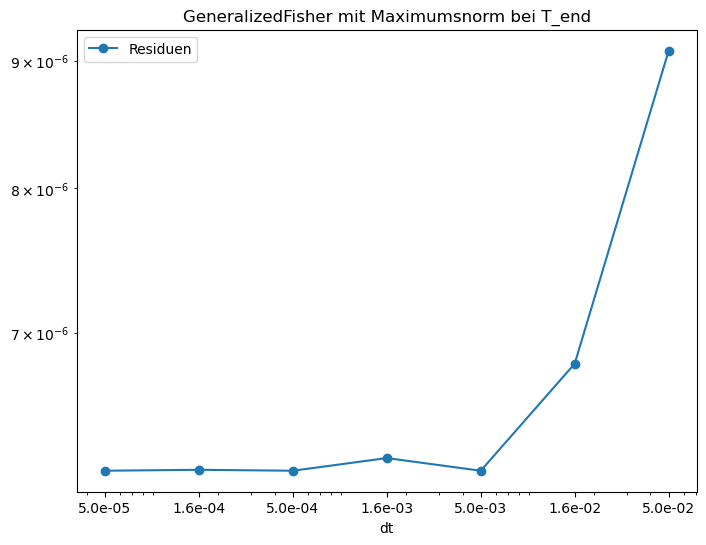

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
conv_line = np.power(dts, 7) * norms[0]/np.power(dts[0], 7)
ax.plot(dts, norms, marker = "o", label="Residuen")
ax.set_xscale("log", base = 10)
ax.set_xticks(dts, labels=dts)
ax.set_yscale("log", base = 10)
ax.set_xticks(dts, labels=["{:.1e}".format(dt) for dt in dts])
plt.xlabel("dt")
plt.legend()
ax.set_title("GeneralizedFisher mit Maximumsnorm bei T_end")
plt.savefig("generalizedfisher_maximumsnorm.png")

# Newton-SDC

In [20]:
def nonlinear_cahn(dt = 0.0005, num_nodes = 4, nvars = (64, 64), nu = 2, eps=0.04,
                  abs_tol = 1E-12, rel_tol = 1E-12, k_max = 10_000, n_max = 10_000):
    # instantiate problem
    prob = allencahn_fullyimplicit(nvars=nvars, nu = nu, eps = eps)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MIN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = cp.asarray(generator.genCoeffs(k=None))

    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = cp.asarray(coll.Qmat[1:, 1:])

    # c = coll.nodes
    # V = cp.fliplr(cp.vander(c))
    # C = cp.diag(c)
    # R = cp.diag([1 / i for i in range(1,coll.num_nodes+1)])
    # print(C @ V @ R @ cp.linalg.inv(V) - Q)
    # exit()


    u0 = cp.asarray(prob.u_exact(t=0).flatten())
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = cp.kron(cp.ones(coll.num_nodes), u0)

    nvars = prob.nvars[0] * prob.nvars[1]

    un = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    fn = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    g = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    # vk = cp.zeros(nvars * coll.num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    timepoints = cp.arange(0, 0.01+dt, step=dt)
    u_buffer = cp.empty((len(timepoints), nvars))
    u_buffer[0, :] = u0
    count = counter()
    
    for index, timepoint in enumerate(timepoints[:-1]):
        n = 0
        while n < n_max:
            # form the function g with g(u) = 0
            for m in range(coll.num_nodes):
                fn[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(un[m * nvars: (m + 1) * nvars].get(),
                                                             t=timepoint + dt * coll.nodes[m]).flatten())
            g[:] = u0_coll - (un - dt * sp.kron(Q, sp.eye(nvars)).dot(fn))
    
            # if g is close to 0, then we are done
            res_newton = cp.linalg.norm(g, cp.inf)
            #print('Newton:', n, res_newton)
    
            if res_newton < abs_tol: # and res_newton/cp.linalg.norm(u0_coll, cp.inf) < rel_tol:
                break
    
            # assemble dg
            dg = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))

    
            # Newton
            # vk =  sp.linalg.spsolve(dg, g)
            # vk = sp.linalg.gmres(dg, g, x0=cp.zeros_like(vk), maxiter=10, atol=1E-10, callback=count)[0]
            # iter_count += count.niter
            # un -= vk
            # continue
    
            # Collocation
            # Emulate Newton
            # dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            # Linear SDC (e.g. with diagonal preconditioner)
            dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            # Linear SDC with frozen Jacobian
            #dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.csr_matrix(prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un[0:nvars] ** prob.nu), offsets=0))
            # dgP = dgP.astype('float64')
    
            # Diagonalization
            # D, V = cp.linalg.eig(Q)
            # Vinv = cp.linalg.inv(V)
            # dg_diag = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(sp.diags(D), prob.A + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un[0:nvars] ** prob.nu), offsets=0))
            # dg_diag = dg_diag.astype('complex64')
    
            vk = cp.zeros(nvars * coll.num_nodes, dtype='float64') #un.copy() #
            res = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    
            res[:] = g - dg.dot(vk)
            k = 0
            while k < k_max:
                # Newton/Collocation: works well with float32 for both P and res, but not for vk
                # vk += sp.linalg.spsolve(dgP, res)
                vk += sp.linalg.gmres(dgP, res, x0=cp.zeros_like(res), maxiter=100, atol=abs_tol)[0]
    
                # Newton/Diagonalization
                # vk += cp.real(sp.kron(V,sp.eye(nvars)).dot(sp.linalg.spsolve(dg_diag, sp.kron(Vinv,sp.eye(nvars)).dot(res))))
                # vk += cp.real(sp.kron(V,sp.eye(nvars)).dot(sp.linalg.gmres(dg_diag, sp.kron(Vinv,sp.eye(nvars)).dot(res), x0=cp.zeros_like(res), maxiter=1, atol=1E-10, callback=count)[0]))
    
                res[:] = g - dg.dot(vk)
                resnorm = cp.linalg.norm(res, cp.inf)
                rel_err = cp.linalg.norm(vk-un, cp.inf)
                #print('   SDC:', n, k, ksum, resnorm)
    
                if resnorm < abs_tol: #and rel_err < rel_tol * cp.linalg.norm(vk, cp.inf):
                    break
                k += 1
                ksum += 1
    
            # Update
            un -= vk
    
            # increase Newton iteration count
            n += 1
            nsum += 1
        temp = un[-nvars:]
        u_buffer[index+1, :] = temp
        u0_coll = cp.kron(cp.ones(coll.num_nodes), temp).flatten()

    return u_buffer, timepoints, prob, ksum, nsum

In [19]:
res_c, time_c, prob_c, ksum, nsum = nonlinear_cahn(dt=0.0005, num_nodes=4, k_max=1, nvars=(64, 64))
cp.linalg.norm(res_c[-1]-cp.asarray(prob_c.u_exact(time_c[-1]).flatten()), cp.inf)

Newton: 0 0.999999808431071
   SDC: 0 0 0 0.19808671753185614
Newton: 1 0.1882788485420167
   SDC: 1 0 1 0.010738356540534288
Newton: 2 0.005017663541714734
   SDC: 2 0 2 0.00016011696860934429
Newton: 3 0.0001604747112660121
   SDC: 3 0 3 4.8898931916567486e-05
Newton: 4 4.8900056847323015e-05
   SDC: 4 0 4 1.4059161658335354e-05
Newton: 5 1.4059199043625625e-05
   SDC: 5 0 5 3.146509112321535e-06
Newton: 6 3.1465115437612212e-06
   SDC: 6 0 6 7.004513789208022e-07
Newton: 7 7.004513274955215e-07
   SDC: 7 0 7 1.6261516654489206e-07
Newton: 8 1.6261516344595606e-07
   SDC: 8 0 8 3.691723139737037e-08
Newton: 9 3.691723127197122e-08
   SDC: 9 0 9 8.271986028130254e-09
Newton: 10 8.271986096097805e-09
   SDC: 10 0 10 1.8378979479411063e-09
Newton: 11 1.837897944945155e-09
   SDC: 11 0 11 4.0604534541107413e-10
Newton: 12 4.0604536399868607e-10
   SDC: 12 0 12 8.937572377765462e-11
Newton: 13 8.937572903988666e-11
   SDC: 13 0 13 1.9638890248189612e-11
Newton: 14 1.963895712719932e-11
  

array(1.18166033e-11)

In [21]:
dts_allen = cp.hstack((0.001, 5/cp.logspace(4, 6, num = 5)))
print(dts_allen)
norms_allen = cp.empty(len(dts_allen))

for index, dt in enumerate(dts_allen):
    print("loop index: " + str(dt))
    u, t, prob, ksum, nsum= nonlinear_cahn(dt = float(dt), num_nodes = 4, abs_tol=1E-14)
    u_exact_allen =cp.asarray(prob.u_exact(t[-1]))
    norms_allen[index] = cp.max(cp.abs(u[-1] - u_exact_allen.flatten()))

[1.00000000e-03 5.00000000e-04 1.58113883e-04 5.00000000e-05
 1.58113883e-05 5.00000000e-06]
loop index: 0.001
loop index: 0.0005
loop index: 0.00015811388300841897
loop index: 5e-05
loop index: 1.5811388300841898e-05
loop index: 5e-06


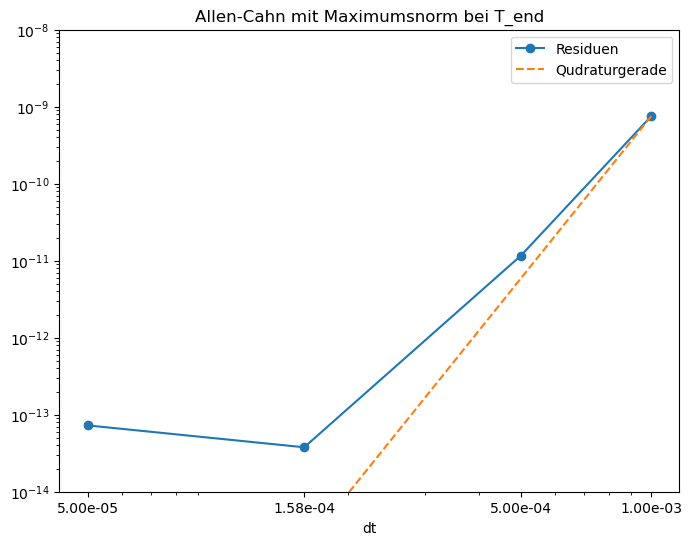

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
dts_allen = dts_allen[:-2]
norms_allen = norms_allen[:-2]
conv_line = cp.power(dts_allen, 7) * norms_allen[0]/np.power(dts_allen[0], 7)
ax.plot(dts_allen.get(), norms_allen.get(), marker = "o", label="Residuen")
ax.plot(dts_allen.get(), conv_line.get(), linestyle="dashed", label="Qudraturgerade")
ax.set_xscale("log", base = 10)
ax.set_xticks(dts_allen.get(), labels=["{:.2e}".format(dt) for dt in dts_allen.get()])
ax.set_yscale("log", base = 10)
ax.set_ylim(1E-14, 1E-8)
plt.xlabel("dt")
plt.legend()
ax.set_title("Allen-Cahn mit Maximumsnorm bei T_end")
plt.savefig("allencahn_maximumsnorm_newsdc.png")

In [23]:
columns = ["method", "problem","tol", "dt", "quad_nodes", "nvars", "sdc_max", "sdc_sum", "new_sum", "norm"]
table = pd.DataFrame(columns=columns)

for dt in [0.0005, 0.00005]:
    for quadn in [2, 3, 4, 5]:
        for nvars in [(64, 64), (128, 128), (256, 256)]:
            for sdciter in [1, 2, 3, 5, 10, 20]:
                print((dt, quadn, nvars, sdciter))
                u, t, prob, ksum, nsum= nonlinear_cahn(dt = float(dt), num_nodes = quadn, abs_tol=1E-12, nvars = nvars, k_max=sdciter)
                max_norm = cp.linalg.norm(u[-1]-cp.asarray(prob.u_exact(t[-1]).flatten()), cp.inf)
                row = ["newton_sdc", "allencahn", 1E-12, dt, quadn, nvars, sdciter, ksum, nsum, max_norm.get()]
                table.loc[len(table.index)] = row

table

(0.0005, 2, (64, 64), 1)
(0.0005, 2, (64, 64), 2)
(0.0005, 2, (64, 64), 3)
(0.0005, 2, (64, 64), 5)
(0.0005, 2, (64, 64), 10)
(0.0005, 2, (64, 64), 20)
(0.0005, 2, (128, 128), 1)
(0.0005, 2, (128, 128), 2)
(0.0005, 2, (128, 128), 3)
(0.0005, 2, (128, 128), 5)
(0.0005, 2, (128, 128), 10)
(0.0005, 2, (128, 128), 20)
(0.0005, 2, (256, 256), 1)
(0.0005, 2, (256, 256), 2)
(0.0005, 2, (256, 256), 3)
(0.0005, 2, (256, 256), 5)
(0.0005, 2, (256, 256), 10)
(0.0005, 2, (256, 256), 20)
(0.0005, 3, (64, 64), 1)
(0.0005, 3, (64, 64), 2)
(0.0005, 3, (64, 64), 3)
(0.0005, 3, (64, 64), 5)
(0.0005, 3, (64, 64), 10)
(0.0005, 3, (64, 64), 20)
(0.0005, 3, (128, 128), 1)
(0.0005, 3, (128, 128), 2)
(0.0005, 3, (128, 128), 3)
(0.0005, 3, (128, 128), 5)
(0.0005, 3, (128, 128), 10)
(0.0005, 3, (128, 128), 20)
(0.0005, 3, (256, 256), 1)
(0.0005, 3, (256, 256), 2)
(0.0005, 3, (256, 256), 3)
(0.0005, 3, (256, 256), 5)
(0.0005, 3, (256, 256), 10)
(0.0005, 3, (256, 256), 20)
(0.0005, 4, (64, 64), 1)
(0.0005, 4, (64

,method,problem,tol,dt,quad_nodes,nvars,sdc_max,sdc_sum,new_sum,norm
0,newton_sdc,allencahn,1.000000e-12,0.00050,2,"(64, 64)",1,187,207,2.2793413507748994e-06
1,newton_sdc,allencahn,1.000000e-12,0.00050,2,"(64, 64)",2,206,122,2.279341276834046e-06
2,newton_sdc,allencahn,1.000000e-12,0.00050,2,"(64, 64)",3,227,83,2.279341235755794e-06
3,newton_sdc,allencahn,1.000000e-12,0.00050,2,"(64, 64)",5,290,62,2.2793410917598678e-06
4,newton_sdc,allencahn,1.000000e-12,0.00050,2,"(64, 64)",10,444,62,2.2793411122989937e-06
...,...,...,...,...,...,...,...,...,...,...
139,newton_sdc,allencahn,1.000000e-12,0.00005,5,"(256, 256)",2,1043,623,1.1558531909372505e-12
140,newton_sdc,allencahn,1.000000e-12,0.00005,5,"(256, 256)",3,1237,609,1.0530187832813453e-12
141,newton_sdc,allencahn,1.000000e-12,0.00005,5,"(256, 256)",5,1437,406,1.0801359806578148e-12
142,newton_sdc,allencahn,1.000000e-12,0.00005,5,"(256, 256)",10,1450,402,1.0840495168196185e-12


In [24]:
table.to_csv("newsdc_cahn_table.csv")

In [26]:
def nonlinear_fisher(dt = 0.05, t_end = 0.1, num_nodes = 4, nvars = 127, abs_tol = 1E-7, rel_tol=1E-7, 
                         k_max = 1_000, n_max = 1_000, nu=1.0, lambda0=2.0 ):
    # instantiate problem
    prob = generalized_fisher(nvars=nvars, nu=nu, lambda0=lambda0)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MIN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = cp.asarray(generator.genCoeffs(k=None))

    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = cp.asarray(coll.Qmat[1:, 1:])

    # c = coll.nodes
    # V = cp.fliplr(cp.vander(c))
    # C = cp.diag(c)
    # R = cp.diag([1 / i for i in range(1,coll.num_nodes+1)])
    # print(C @ V @ R @ cp.linalg.inv(V) - Q)
    # exit()


    u0 = cp.asarray(prob.u_exact(t=0).flatten())
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = cp.kron(cp.ones(coll.num_nodes), u0)

    nvars = prob.nvars

    un = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    fn = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    g = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    # vk = cp.zeros(nvars * coll.num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    timepoints = cp.arange(0, 0.01+dt, step=dt)
    u_buffer = cp.empty((len(timepoints), nvars))
    u_buffer[0, :] = u0
    count = counter()
    
    for index, timepoint in enumerate(timepoints[:-1]):
        n = 0
        while n < n_max:
            # form the function g with g(u) = 0
            for m in range(coll.num_nodes):
                fn[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(un[m * nvars: (m + 1) * nvars].get(),
                                                             t=float(timepoint) + dt * coll.nodes[m]).flatten())
            g[:] = u0_coll - (un - dt * sp.kron(Q, sp.eye(nvars)).dot(fn))
    
            # if g is close to 0, then we are done
            res_newton = cp.linalg.norm(g, cp.inf)
            #print('Newton:', n, res_newton)
    
            if res_newton < abs_tol:# and res_newton/cp.linalg.norm(u0_coll, cp.inf) < rel_tol:
                break
    
            # assemble dg
            #dg = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A[1:-1, 1:-1]) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            laplace_dif = sp.kron(sp.eye(num_nodes), prob.A[1:-1, 1:-1])
            growth_dif = cp.power(prob.lambda0, 2)* sp.diags(1.0-(prob.nu + 1) *cp.power(un, prob.nu), offsets=0)
            dg = -sp.eye(nvars * num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(laplace_dif + growth_dif)
    
            # Newton
            # vk =  sp.linalg.spsolve(dg, g)
            # vk = sp.linalg.gmres(dg, g, x0=cp.zeros_like(un), maxiter=100, atol=abs_tol, callback=count)[0]
            # iter_count += count.niter
            # un -= vk
            # continue
    
            # Collocation
            # Emulate Newton
            # dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            #dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(num_nodes), sp.csr_matrix(prob.A[1:-1, 1:-1])) + cp.power(prob.lambda0, 2) * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            # Linear SDC (e.g. with diagonal preconditioner)
            #dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(sp.kron(sp.eye(num_nodes), sp.csr_matrix(prob.A[1:-1, 1:-1])) + cp.power(prob.lambda0, 2) * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            # Linear SDC with frozen Jacobian
            dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.csr_matrix(prob.A[1:-1, 1:-1]) + cp.power(prob.lambda0, 2) * sp.diags((1.0 - (prob.nu + 1) * un[-nvars:] ** prob.nu), offsets=0))
            #dgP = dgP.astype('float64')
    
            # Diagonalization
            # D, V = cp.linalg.eig(Q)
            # Vinv = cp.linalg.inv(V)
            # dg_diag = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(sp.diags(D), prob.A + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un[0:nvars] ** prob.nu), offsets=0))
            # dg_diag = dg_diag.astype('complex64')
    
            vk = cp.zeros(nvars * coll.num_nodes, dtype='float64') #un.copy() 
            res = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    
            res[:] = g - dg.dot(vk)
            k = 0
            while k < k_max:
                # Newton/Collocation: works well with float32 for both P and res, but not for vk
                # vk += sp.linalg.spsolve(dgP, res)
                vk += sp.linalg.gmres(dgP, res, x0=vk, maxiter=1000, atol=abs_tol)[0]
    
                # Newton/Diagonalization
                # vk += cp.real(sp.kron(V,sp.eye(nvars)).dot(sp.linalg.spsolve(dg_diag, sp.kron(Vinv,sp.eye(nvars)).dot(res))))
                # vk += cp.real(sp.kron(V,sp.eye(nvars)).dot(sp.linalg.gmres(dg_diag, sp.kron(Vinv,sp.eye(nvars)).dot(res), x0=cp.zeros_like(res), maxiter=1, atol=1E-10, callback=count)[0]))
    
                res[:] = g - dg.dot(vk)
                resnorm = cp.linalg.norm(res, cp.inf)
                rel_err = cp.linalg.norm(vk-un, cp.inf)
                #print('   SDC:', n, k, ksum, resnorm)
    
                if resnorm < abs_tol: #and rel_err < rel_tol * cp.linalg.norm(vk, cp.inf):
                    break
                k += 1
                ksum += 1
    
            # Update
            un -= vk
    
            # increase Newton iteration count
            n += 1
            nsum += 1
        temp = un[-nvars:]
        u_buffer[index+1, :] = temp
        u0_coll = cp.kron(cp.ones(coll.num_nodes), temp).flatten()

    return u_buffer, timepoints, prob, ksum, nsum

In [30]:
res_f, time_f, prob_f, ksum, nsum = nonlinear_fisher(num_nodes = 4, abs_tol=1E-12, k_max=1, nvars=255, dt=5E-4)
cp.linalg.norm(res_f[-1]-cp.asarray(prob_f.u_exact(float(time_f[-1])).flatten()), cp.inf)

array(1.56979533e-07)

In [32]:
dts = 5/cp.logspace(2, 5, num=7)
norms = cp.empty(len(dts))

for index, dt in enumerate(dts):
    print("loop index: " + str(dt))
    u, t, prob, ksum, nsum = nonlinear_fisher(dt = float(dt), abs_tol=1E-12)
    norms[index] = cp.linalg.norm(res_f[-1]-cp.asarray(prob_f.u_exact(float(time_f[-1])).flatten()), cp.inf)

loop index: 0.05
loop index: 0.0158113883008419
loop index: 0.005
loop index: 0.0015811388300841895
loop index: 0.0005
loop index: 0.00015811388300841897
loop index: 5e-05


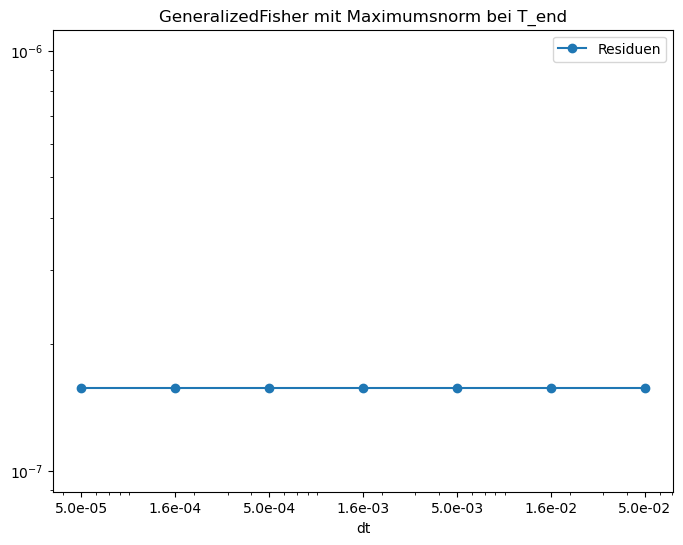

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dts.get(), norms.get(), marker = "o", label="Residuen")
ax.set_xscale("log", base = 10)
ax.set_xticks(dts.get(), labels=dts.get())
ax.set_yscale("log", base = 10)
ax.set_xticks(dts.get(), labels=["{:.1e}".format(dt) for dt in dts.get()])
plt.xlabel("dt")
plt.legend()
ax.set_title("GeneralizedFisher mit Maximumsnorm bei T_end")
plt.savefig("generalizedfisher_maximumsnorm_newsdc.png")

In [36]:
columns = ["method", "problem","tol", "dt", "quad_nodes", "nvars", "sdc_max", "sdc_sum", "new_sum", "norm"]
table = pd.DataFrame(columns=columns)

for dt in [0.0005, 0.00005]:
    for quadn in [2, 3, 4, 5]:
        for nvars in [63, 127, 255]:
            for sdciter in [1, 2, 3, 5, 10, 20]:
                print((dt, quadn, nvars, sdciter))
                u, t, prob, ksum, nsum = nonlinear_fisher(num_nodes = quadn, abs_tol=1E-12, dt=float(dt), nvars=nvars, k_max=sdciter)
                max_norm = cp.linalg.norm(u[-1]-cp.asarray(prob.u_exact(float(t[-1])).flatten()), cp.inf)
                row = ["newton_sdc", "allencahn", 1E-12, dt, quadn, nvars, sdciter, ksum, nsum, max_norm.get()]
                table.loc[len(table.index)] = row

table

(0.0005, 2, 63, 1)
(0.0005, 2, 63, 2)
(0.0005, 2, 63, 3)
(0.0005, 2, 63, 5)
(0.0005, 2, 63, 10)
(0.0005, 2, 63, 20)
(0.0005, 2, 127, 1)
(0.0005, 2, 127, 2)
(0.0005, 2, 127, 3)
(0.0005, 2, 127, 5)
(0.0005, 2, 127, 10)
(0.0005, 2, 127, 20)
(0.0005, 2, 255, 1)
(0.0005, 2, 255, 2)
(0.0005, 2, 255, 3)
(0.0005, 2, 255, 5)
(0.0005, 2, 255, 10)
(0.0005, 2, 255, 20)
(0.0005, 3, 63, 1)
(0.0005, 3, 63, 2)
(0.0005, 3, 63, 3)
(0.0005, 3, 63, 5)
(0.0005, 3, 63, 10)
(0.0005, 3, 63, 20)
(0.0005, 3, 127, 1)
(0.0005, 3, 127, 2)
(0.0005, 3, 127, 3)
(0.0005, 3, 127, 5)
(0.0005, 3, 127, 10)
(0.0005, 3, 127, 20)
(0.0005, 3, 255, 1)
(0.0005, 3, 255, 2)
(0.0005, 3, 255, 3)
(0.0005, 3, 255, 5)
(0.0005, 3, 255, 10)
(0.0005, 3, 255, 20)
(0.0005, 4, 63, 1)
(0.0005, 4, 63, 2)
(0.0005, 4, 63, 3)
(0.0005, 4, 63, 5)
(0.0005, 4, 63, 10)
(0.0005, 4, 63, 20)
(0.0005, 4, 127, 1)
(0.0005, 4, 127, 2)
(0.0005, 4, 127, 3)
(0.0005, 4, 127, 5)
(0.0005, 4, 127, 10)
(0.0005, 4, 127, 20)
(0.0005, 4, 255, 1)
(0.0005, 4, 255, 2)
(0

,method,problem,tol,dt,quad_nodes,nvars,sdc_max,sdc_sum,new_sum,norm
0,newton_sdc,allencahn,1.000000e-12,0.00050,2,63,1,21,83,2.5052895247235085e-06
1,newton_sdc,allencahn,1.000000e-12,0.00050,2,63,2,21,83,2.5052895247235085e-06
2,newton_sdc,allencahn,1.000000e-12,0.00050,2,63,3,21,83,2.5052895247235085e-06
3,newton_sdc,allencahn,1.000000e-12,0.00050,2,63,5,21,83,2.5052895247235085e-06
4,newton_sdc,allencahn,1.000000e-12,0.00050,2,63,10,21,83,2.5052895247235085e-06
...,...,...,...,...,...,...,...,...,...,...
139,newton_sdc,allencahn,1.000000e-12,0.00005,5,255,2,2,803,1.569795334832591e-07
140,newton_sdc,allencahn,1.000000e-12,0.00005,5,255,3,2,803,1.569795334832591e-07
141,newton_sdc,allencahn,1.000000e-12,0.00005,5,255,5,2,803,1.569795334832591e-07
142,newton_sdc,allencahn,1.000000e-12,0.00005,5,255,10,2,803,1.569795334832591e-07


In [37]:
table.to_csv("newsdc_fisher_table.csv")